### 0. Install necessary packages

In [1]:
import time
import numpy as np
import matplotlib as plt

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

from preprocessing import Preprocess
from models import full_model, attention_model
from utils import total_parameters, scheduler, cost_function
from evaluation import EvaluateModel

2024-12-06 18:27:48.950804: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 18:27:48.951366: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 18:27:48.953887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 18:27:48.960607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733506068.971793  101964 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733506068.97

### 1. Load the data

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test, m, s = Preprocess(time_steps=5, start_year=2000, save=False)

--- Preprocessing ---
Remove low yield observations:  2
of years:  [1988. 2003.]
Full train data available:  (24311, 393)
Train data used: (10707, 397), starting from 2000
- Preprocessed data -
Train data (10707, 397, 1)
Validation data (560, 397, 1)
Test data (472, 397, 1)
Test data has mean 1.5 and std 0.99.



### 2. Set hyperparameters and initialize models

In [3]:
Max_it = 4
learning_rate = 0.0006        # Learning rate

# Loss function parameters
alpha = 1                     # Weight of loss for final time step
beta = 1                      # Weight of loss for years before final time steps

# LSTM parameters
time_steps = 5                # Number of time steps for the RNN
num_units = 64                # Number of hidden units for LSTM cells
num_layers = 2                # Number of layers of LSTM cell
dropout = 0.3                 # Dropout rate

# Attention parameters
num_heads = 4
key_dim = 32

In [4]:
og_model = full_model(time_steps, num_units, num_layers, dropout)
og_model.compile(optimizer = Adam(learning_rate = learning_rate), loss = cost_function(alpha, beta))
print("Total parameters of the original model: ",total_parameters(og_model), "\n")

att_model = attention_model(time_steps, num_units, num_layers, dropout, num_heads, key_dim)
att_model.compile(optimizer = Adam(learning_rate = learning_rate), loss = cost_function(alpha, beta))
print("Total parameters of the attention model: ",total_parameters(att_model), "\n")

W0000 00:00:1733506071.208322  101964 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



--- Model Architecture ---
 - CNN for Weather data - 
Output W-CNN: (None, 66)
 - CNN for Soil data - 
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (None, 1)
Total parameters of the original model:  112659 


--- Model Architecture ---
 - CNN for Weather data - 
Output W-CNN: (None, 66)
 - Multi-Head Attention for Weather data - 
Output W-Attention: (None, 66, 1)
 - CNN for Soil data - 
Output S-CNN: (None, 44)
 - Multi-Head Attention for Soil data - 
Output S-Attention: (None, 44, 1)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (No

### 3. Train models

In [5]:
lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.0001)

In [6]:
t1=time.time()
og_history = og_model.fit(X_train, y_train,
                    epochs = Max_it,
                    validation_data = (X_val, y_val),
                    callbacks = [lr_scheduler, early_stopping])
t2=time.time()
print("Time taken for training the original model: ", t2-t1)

Epoch 1/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 1.0243 - val_loss: 0.3953 - learning_rate: 6.0000e-04
Epoch 2/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2985 - val_loss: 0.2510 - learning_rate: 6.0000e-04
Epoch 3/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2090 - val_loss: 0.2002 - learning_rate: 6.0000e-04
Epoch 4/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1729 - val_loss: 0.2809 - learning_rate: 6.0000e-04
Time taken for training the original model:  23.263749599456787


In [7]:
t3=time.time()
att_history = att_model.fit(X_train, y_train,
                    epochs = Max_it,
                    validation_data = (X_val, y_val),
                    callbacks = [lr_scheduler, early_stopping])
t4=time.time()
print("Time taken for training the attention model: ", t4-t3)

Epoch 1/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 1.0548 - val_loss: 0.3250 - learning_rate: 6.0000e-04
Epoch 2/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2682 - val_loss: 0.2110 - learning_rate: 6.0000e-04
Epoch 3/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1870 - val_loss: 0.1904 - learning_rate: 6.0000e-04
Epoch 4/4
335/335 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1599 - val_loss: 0.1554 - learning_rate: 6.0000e-04
Time taken for training the attention model:  29.70540165901184


In [8]:
og_model.save('../models/og_model.keras')
att_model.save('../models/att_model.keras')

### 4. Evaluation

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training RMSE: 5.154306230852109
Validation RMSE: 5.361231095098712
Training MAE: 3.93266974001859
Validation MAE: 4.122924113793732
Training R²: 0.7761123120917556
Validation R²: 0.6750155422954287


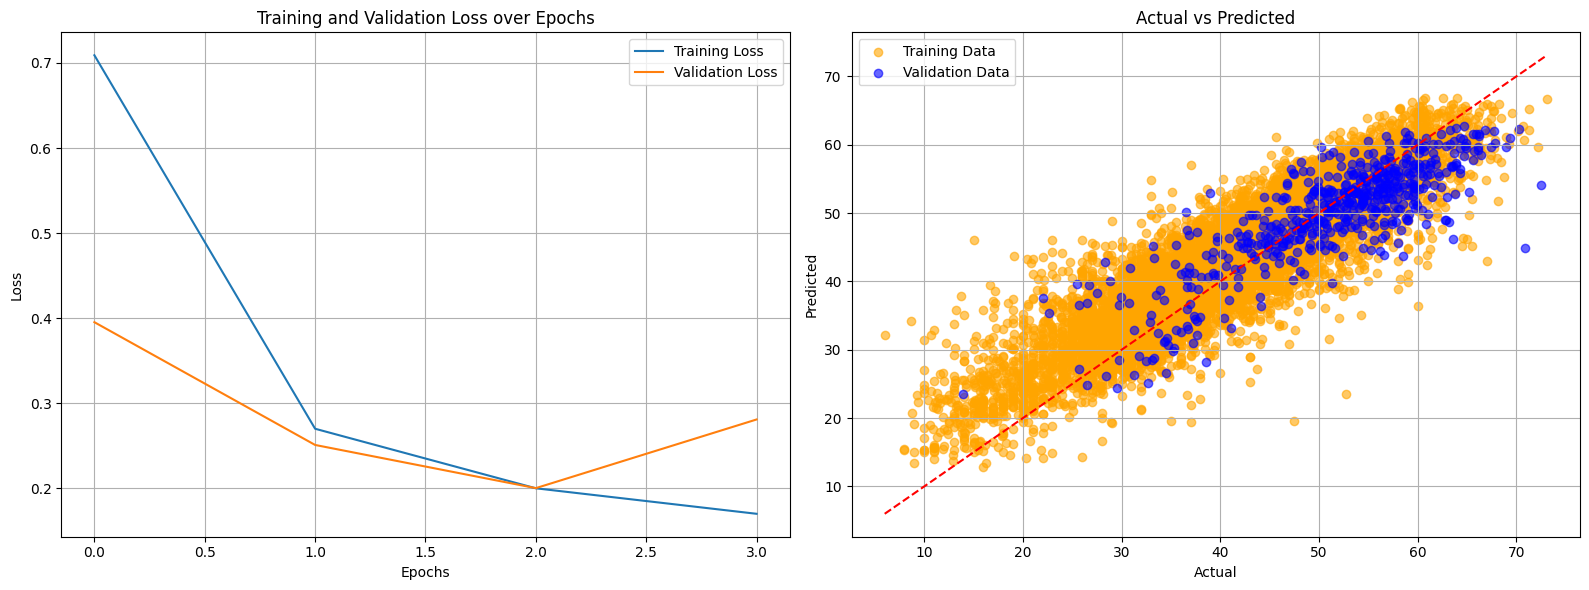

In [9]:
og_evaluator = EvaluateModel(og_model, X_train, y_train, X_val, y_val, s, m)
og_evaluator.evaluate(history=og_history)

335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training RMSE: 4.9012691949119
Validation RMSE: 5.062574684836873
Training MAE: 3.6185584837840774
Validation MAE: 3.8526951286264
Training R²: 0.7975550775791669
Validation R²: 0.710214652683193


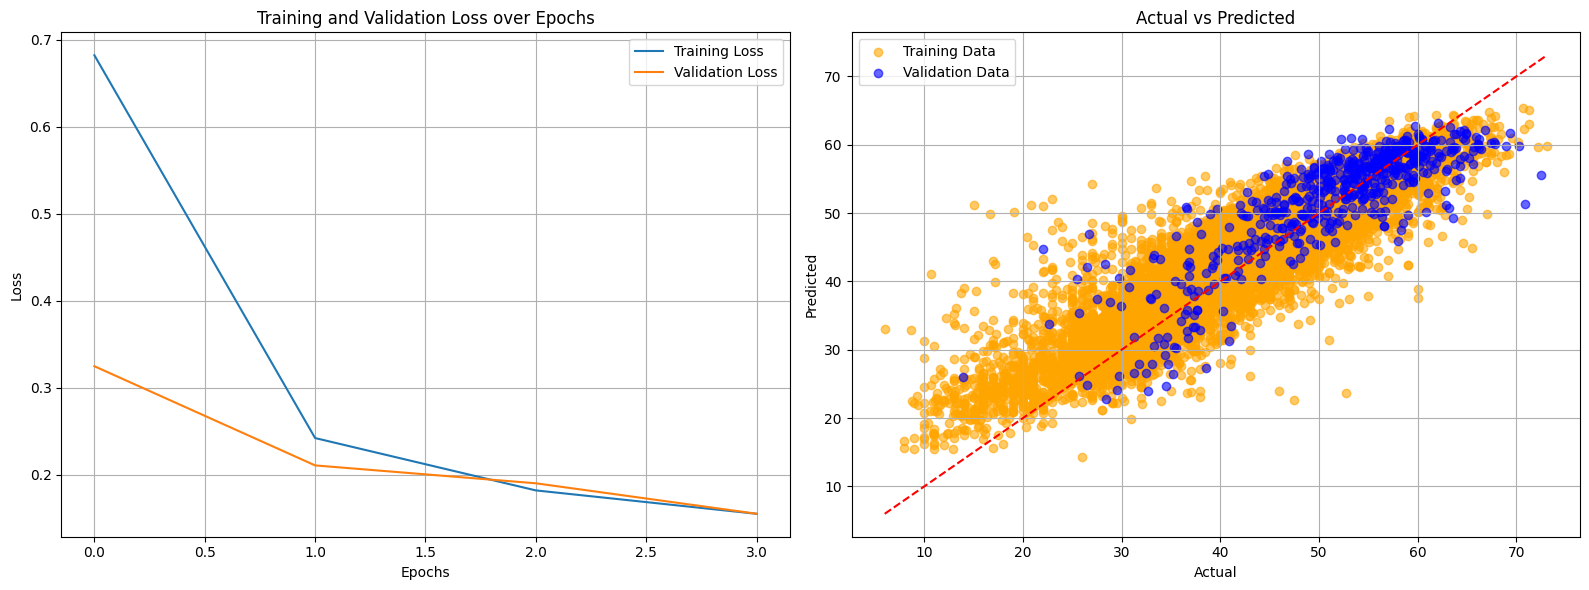

In [10]:
att_evaluator = EvaluateModel(att_model, X_train, y_train, X_val, y_val, s, m, att=True)
att_evaluator.evaluate(att_history)

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


TypeError: Invalid shape (10707, 4, 66, 66) for image data

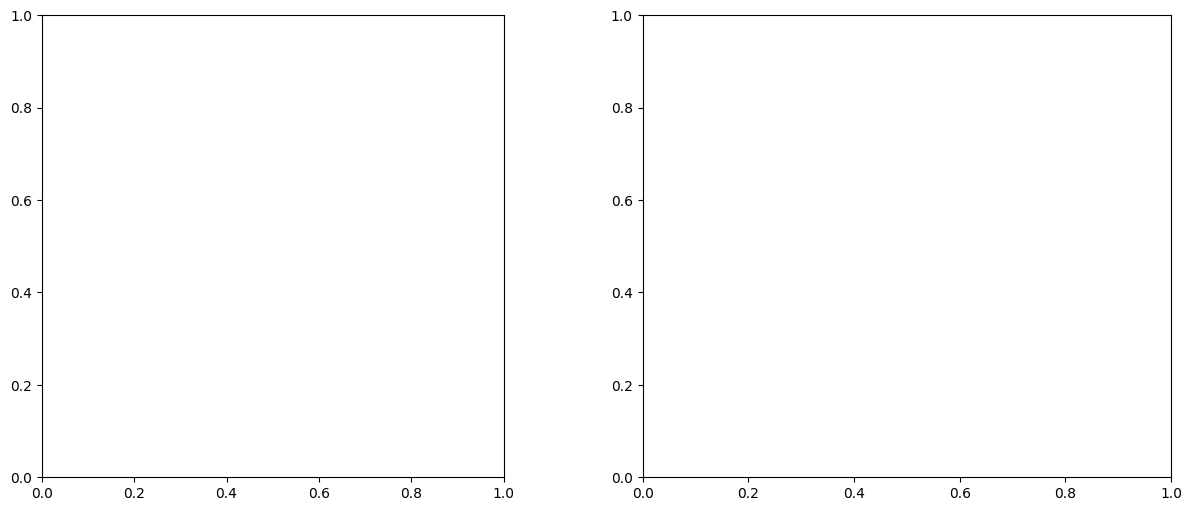

In [11]:
att_evaluator.visualize_attention(X_train)

In [ ]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)